# Customer Experience Analysis at E-commerce company
As an e-commerce company whose revenue is generated from sales charge by sellers, it's important to manage customer experience in order to encourage customers' purchase. Condisering the same product is being sold in a different shopping platform with a similar price range, keeping customers satisfaction rate high is very important. What is the main factor that affect customer shopping experience most, and what are the action plan we can take?
The dataset has been provided by a Brazilian online e-commerce company, Olist, and has been accumulated over the past 2 years from Sep 2016 to Sep 2018.

## Table of Contents
1. Data Preprocessing
2. Exploratory Data Analysis
3. Classification & Permutation Feature Importance
3. Conclusion & Action Plan

## 1. Data Preprocessing

In [50]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from wordcloud import STOPWORDS
pd.set_option('display.max_columns', 100)

In [51]:
items = pd.read_csv("olist_order_items_dataset.csv")
review = pd.read_csv("olist_order_reviews_dataset.csv")
product = pd.read_csv("olist_products_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
payment = pd.read_csv("olist_order_payments_dataset.csv")
translate = pd.read_csv("product_category_name_translation.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

df = pd.merge(review, items, on= 'order_id', how = 'inner')
df= df.merge(product, on = 'product_id', how = 'inner')
df= df.merge(orders, on = 'order_id', how = 'inner')
df= df.merge(payment, on = 'order_id', how = 'inner')
df = df.merge(customers, on = 'customer_id', how = 'inner')
df = pd.merge(df, sellers, on = 'seller_id', how = 'inner')
df.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,14600,sao joaquim da barra,SP
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-01-18 15:47:59,185.0,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,2018-01-11 15:47:59,2018-01-12 21:57:22,2018-01-17 18:42:41,2018-02-02 00:00:00,1,credit_card,8,397.26,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP,14600,sao joaquim da barra,SP
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,NaN,2018-04-10 00:00:00,2018-04-11 11:30:43,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2018-04-02 11:15:38,185.0,20.26,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,b1757da2a461d581e1a3b280ca181b7c,delivered,2018-03-26 11:02:31,2018-03-26 11:15:38,2018-03-26 22:58:37,2018-04-09 21:53:23,2018-04-27 00:00:00,1,credit_card,3,205.26,059ba8400bf965adf606ecc7ef3396e9,95860,taquari,RS,14600,sao joaquim da barra,SP
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NaN,NaN,2017-12-28 00:00:00,2017-12-30 12:07:50,1,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,2017-12-14 20:51:05,185.0,17.05,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,da2bd16b131bc90653b87fe4d8fd266e,delivered,2017-12-07 20:33:24,2017-12-07 20:51:05,2017-12-08 18:12:34,2017-12-27 18:19:53,2018-01-08 00:00:00,1,credit_card,2,202.05,62a25a159f9fd2ab7c882d9407f49aa9,36500,uba,MG,14600,sao joaquim da barra,SP
4,5fdb2ed7aa0f1b1c9642175b302e38af,b0bc656fed47584c160f8cff2d7b8bbd,5,NaN,NaN,2018-03-17 00:00:00,2018-03-17 17:36:27,1,1acb18fc869c5489d5f76abcd681165e,6d803cb79cc31c41c4c789a75933b3c7,2018-03-06 14:10:22,135.0,18.20,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,f4ad1c9eb0bed4469cbe0ff8f47bf634,delivered,2018-02-27 13:56:12,2018-02-27 14:10:22,2018-02-27 23:04:47,2018-03-16 14:16:19,2018-03-23 00:00:00,1,credit_card,1,306.40,86243f3e50e3b844b1d7bd850c4d2623,38412,uberlandia,MG,14600,sao joaquim da barra,SP


In [52]:
# replacing Portuguese category names with English names

df = df.join(translate.set_index('product_category_name')['product_category_name_english'], on = 'product_category_name')
df.drop(columns = 'product_category_name', inplace = True)
df.rename({'product_category_name_english': 'product_category'},axis= "columns", inplace = True)
df['product_category'].sample(3)

44496                    furniture_decor
50205                               baby
58378    construction_tools_construction
Name: product_category, dtype: object

In [53]:
# checking for datatypes - datetime & category

dtime = ['review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 
         'order_estimated_delivery_date', 'order_approved_at']

for d in dtime:
    df[d] = df[d].astype('datetime64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      118315 non-null  object        
 1   order_id                       118315 non-null  object        
 2   review_score                   118315 non-null  int64         
 3   review_comment_title           14089 non-null   object        
 4   review_comment_message         50665 non-null   object        
 5   review_creation_date           118315 non-null  datetime64[ns]
 6   review_answer_timestamp        118315 non-null  datetime64[ns]
 7   order_item_id                  118315 non-null  int64         
 8   product_id                     118315 non-null  object        
 9   seller_id                      118315 non-null  object        
 10  shipping_limit_date            118315 non-null  object        
 11  

In [54]:
# checking for missing values in all columns

df['product_category'] = df['product_category'].fillna("no_data")

avg = ['product_description_lenght', 'product_photos_qty', 'product_name_lenght','product_weight_g', 'product_height_cm', 'product_length_cm', 'product_width_cm']
review = ['review_comment_title', 'review_comment_message']

for i in avg:
    df[i].fillna(df[i].mean(), inplace = True)
        
for a in review:
    df[a].fillna('NA', inplace= True)

# handling missing values

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_estimated_delivery_date"].fillna(df["order_delivered_customer_date"], inplace=True)
df['order_delivered_carrier_date'].fillna(df['order_approved_at'], inplace = True)
df['order_delivered_customer_date'].fillna(df["order_estimated_delivery_date"], inplace = True)

df.isna().sum()

review_id                        0
order_id                         0
review_score                     0
review_comment_title             0
review_comment_message           0
review_creation_date             0
review_answer_timestamp          0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_sequential               0
payment_type        

In [55]:
# removing duplicates

df.drop_duplicates(subset = {'order_id', 'product_id', 'order_item_id'}, inplace = True)

### 2. Exploratory Data Analysis

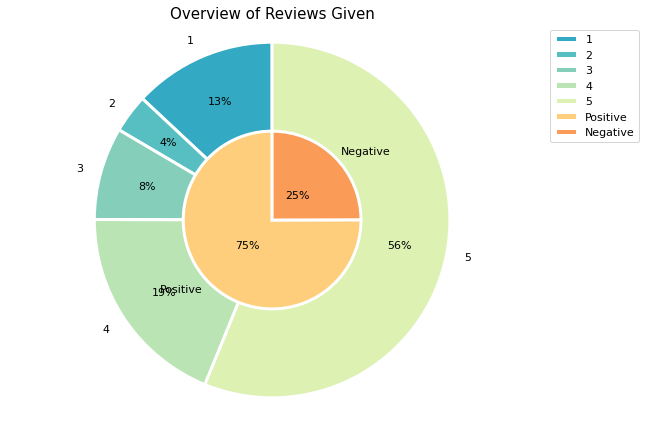

In [56]:
# Let's first divide positive reviews with score higher than 3, and negative reviews with score lower than 3.

def division(x):
    if x<=3:
        return "1"
    else: return "0"

df['reaction'] = df['review_score'].apply(division)
df['reaction'] =df['reaction'].astype(int)

palette = sns.color_palette("Paired", 2)
palette_o = sns.color_palette("YlGnBu", 10)
palette_i = sns.color_palette("Spectral",10)

outer = [palette_o[5],palette_o[4],palette_o[3],palette_o[2], palette_o[1]]
inner = [palette_i[3], palette_i[2]]
color_list = [palette[0], palette[1]]

number = df['review_score'].value_counts().sort_index(ascending=True).values
labels_2 = ['1','2', '3', '4', '5']
x2 = [number[0],number[1], number[2], number[3], number[4]]
labels_3 =['Positive','Negative']
x3 = [df['reaction'].value_counts().values[0],df['reaction'].value_counts().values[1]]

plt.figure(figsize=(9,6))
plt.pie(x2,startangle=90, labels = labels_2, pctdistance =0.73,colors=outer,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.4)
plt.pie(x3,startangle=90, labels = labels_3, pctdistance =0.4,colors=inner,textprops ={'fontsize':11},
        wedgeprops = {'linewidth' : 3, 'edgecolor' : "w" }, autopct = '%1.0f%%',radius= 0.2 )
plt.axis('equal') 
plt.legend(loc=1, bbox_to_anchor=(0.8, 0., 0.4, 1), fontsize =11)
plt.title("Overview of Reviews Given", size = 15)
plt.tight_layout();

I have classified score 4,5 as Positive reaction and 3,4,5 as Negative reaction.
Most, 75%, of the reviews are positive while only 25% is negative. It means that we have an imbalanced dataset that requires attention in the machine learning part later!

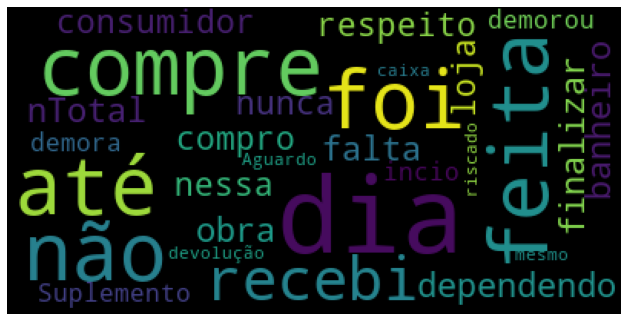

In [57]:
stopwords = {'para', 'mas', 'do', 'e', 'em','um','dezembro','produtos', 'uma', 'todos', "NA'",'lado', 'estou', 'pra', 'ou','de', 'o', 'a', 'no', 'nan', 'Quero', 'ate','os','NA',
             'quase', 'produto','vieram','aqui', 'veio', 'mes', 'so', 'ano', 'eu', 'un', 'dizer', "un'",'acabou', 'contudo','outro', 'nQuer','pois','chegar','passado', "outro'",
            'unidades', 'hoje', 'r', 'n', 'comprei', 'que', 'apos', 'mais', 'apos', 'tive', 'com', 'meu', 'q', 'boa', 'fizerao', 'isso', 'dele', 'mim', '200g', 'vida', 'compra',
            'lannister', 'seja', 'aumentei', 'valor', 'universal', 'creatina', 'dá', 'Daí', 'só', 'sem','Estão', 'além', 'chegaria', 'demais'}

below_3 = df[df['review_score']<3]
text = below_3['review_comment_message'].values
wordcloud = WordCloud(stopwords=stopwords)
wordcloud = wordcloud.generate(str(text))
plt.figure(figsize = (11,14))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Here I have used Wordcloud to analyse what exactly customers left on the comment. After removing less relevant sentences I have categorized the main cause of negative experience as below;

1. Wrong delivery (Seller missed some of the ordered products, or broken / wrong product has been delivered):
quantitade, unidade (amount), errada (wrong), faltando (missing), direoto (right), sem (lack), riscado (damaged) -> product count that is ordered simultaneously, seller score, selling count

2. Delayed delivery: 
ainda (not yet), entrega, demora (delivery), correio (post), frete (freight), chegou (has arrived), sem (week), tarde, atrasado, demorou (late), nAguardo (I wait) -> Delivery hours, regions

Based on this prior knowledge we are going to proceed with an analysis.

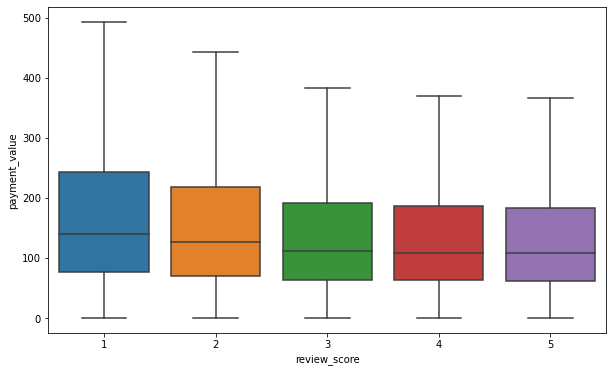

In [58]:
plt.figure(figsize = (10,6))
sns.boxplot(df['review_score'], df['payment_value'], showfliers=False);

Every point of box plot, from 1 IQR to 4 IQR are higher in lower score than higher score. This means that customers who purchased more expensitve stuff tend to write negative reviews, probably because of high expectations. 

In [59]:
df.groupby('review_score')['product_description_lenght'].agg(['mean', 'std'])

,mean,std
review_score,,
1,778.505136,653.949742
2,738.706227,602.899209
3,771.605810,637.862873
4,794.622211,641.463678
5,793.214372,651.922058


Products description length tends to be shorter for negative customer experience. This is probably because product page failed to provide detailed explanation, leading to customers' false expectation. Or it's just reflects that a seller doesn't pay much attention to overall sales activity, not only product page creation but also delivery etc. (but not a big difference)

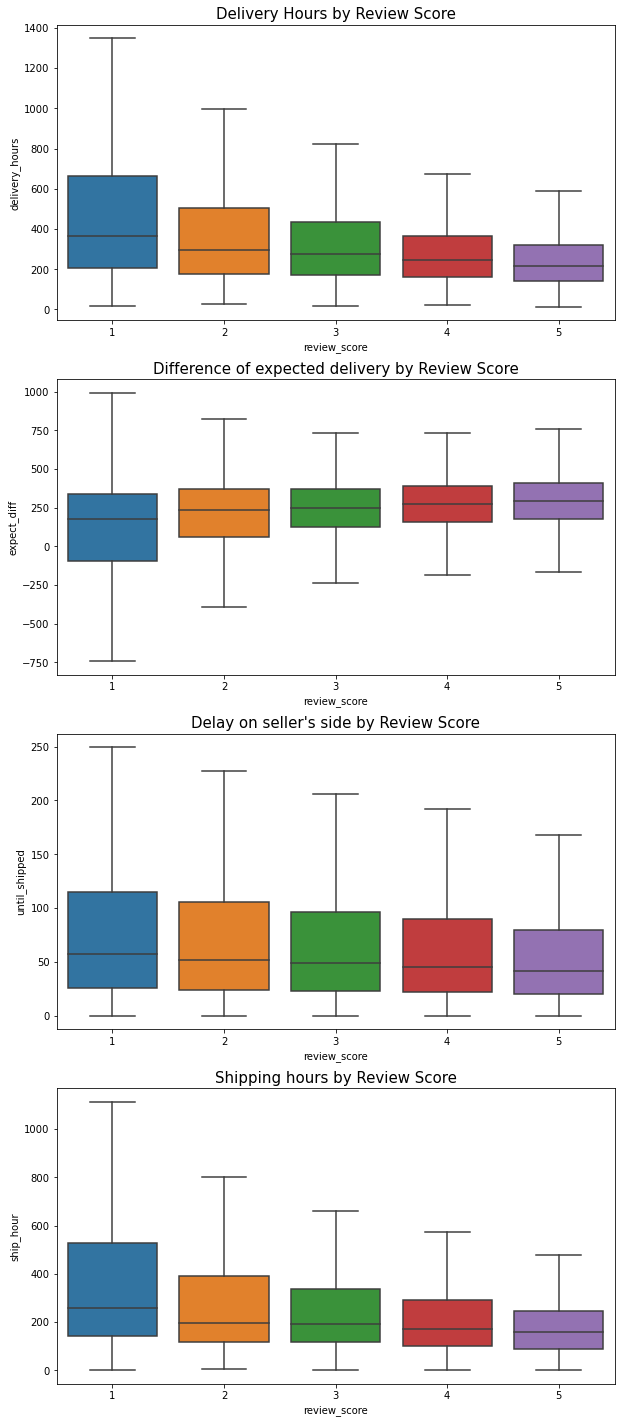

In [60]:
df['delivery_time'] = df['order_delivered_customer_date'] - df['order_approved_at']
df['delivery_hours'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('delivery_hours > 0') 

df['delivery_time'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']
df['expect_diff'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))

df['delivery_time'] = df['order_delivered_carrier_date'] - df['order_approved_at']
df['until_shipped'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('until_shipped > 0') 

df['delivery_time'] = df['order_delivered_customer_date'] - df['order_delivered_carrier_date']
df['ship_hour'] = df['delivery_time'].apply(lambda x: x/np.timedelta64(1,'h'))
df = df.query('ship_hour > 0') 

plt.figure(figsize =(10,25))
plt.subplot(4,1,1)
sns.boxplot(df['review_score'], df['delivery_hours'], showfliers = False)
plt.title("Delivery Hours by Review Score", size = 15)

ax_0 = plt.subplot(4,1,2)
sns.boxplot(df['review_score'], df['expect_diff'], showfliers = False, ax= ax_0)
plt.title("Difference of expected delivery by Review Score", size = 15)
ax_1 = plt.subplot(4,1,3)
sns.boxplot(df['review_score'], df['until_shipped'], showfliers = False, ax = ax_1)
plt.title("Delay on seller's side by Review Score", size = 15)

ax_2 = plt.subplot(4,1,4)
sns.boxplot(df['review_score'], df['ship_hour'], showfliers = False, ax = ax_2)
plt.title("Shipping hours by Review Score", size = 15);

We can easily guess that customer experience is heavily influenced by delivery duration. This is true for the significant difference between expected delivery and actual delivery, and a delay made by seller until the product is shipped out, and actual shipping duration

In [61]:
df.groupby(['product_category'])['review_score'].agg(['mean', 'std']).sort_values(by ='mean', ascending = True)

,mean,std
product_category,,
security_and_services,2.500000,2.121320
diapers_and_hygiene,3.315789,1.526438
home_comfort_2,3.366667,1.751518
office_furniture,3.500300,1.526593
fashion_male_clothing,3.692913,1.673850
...,...,...
costruction_tools_tools,4.392157,1.178662
books_imported,4.490909,1.152658
books_general_interest,4.495274,1.053708


Mean & standard deviation of review score varies in each product category. We have already seen that products with higher unit price is related to lower customer satisfaction score. However this table doens't particularly show the connection between price and customer satisfaction. I don't think diapers are more expensive than children clothes. Therefore the difference in product category is due to issues with product or seller.

In [62]:
df.groupby(['payment_type'])['review_score'].agg(['mean', 'std'])

,mean,std
payment_type,,
boleto,4.036707,1.375840
credit_card,4.041398,1.379713
debit_card,4.177518,1.297650
voucher,4.020841,1.399365


Customers who paid with debit card got satisfied more than others with different payment types. Voucher, in contrary, is likely to cause more trouble in expiry date, transaction amount etc, which could have led lower satisfaction score.

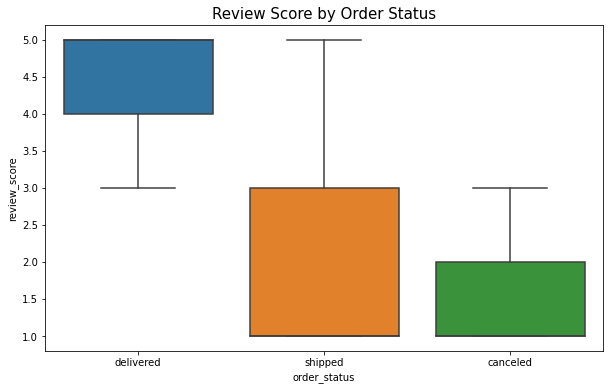

In [63]:
plt.figure(figsize =(10,6))
sns.boxplot(df['order_status'], df['review_score'], showfliers = False)
plt.title("Review Score by Order Status", size = 15);

Orders with shipped & canceled status obviously got a low review score, since it means the orders ended up with shipped & canceled status without successfully delivering.

In [64]:
df.groupby(['customer_state'])['review_score'].agg(['mean', 'std']).sort_values(by ='mean', ascending = True)

,mean,std
customer_state,,
RR,3.580000,1.591944
MA,3.693928,1.542371
PA,3.761054,1.506204
AL,3.777778,1.509957
BA,3.795100,1.474359
RJ,3.801483,1.553519
CE,3.814969,1.493768
SE,3.827225,1.534038
PI,3.935361,1.415427


There are differences in mean score between states. Given that customer satisfaction score is highly affected by delivery hours, this could be caused by logistics infrastructure in each state.

In [66]:
df['review_year'] = df['review_answer_timestamp'].dt.year
df['review_month'] = df['review_answer_timestamp'].dt.month
df['review_dayofweek'] = df['review_answer_timestamp'].dt.dayofweek
df['review_day'] = df['review_answer_timestamp'].dt.day
df['review_hour'] = df['review_answer_timestamp'].dt.hour
df['review_month'] = df.review_month.map("{:02}".format)
df['review_year'] = df.review_year.map("{:02}".format)
df['review_ym'] = df['review_year'].astype(str) + df['review_month'].astype(str)

df['purchase_year'] = df['order_purchase_timestamp'].dt.year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_day'] = df['order_purchase_timestamp'].dt.day
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour

In [67]:
df.groupby(['review_dayofweek'])['review_score'].agg(['mean', 'std'])

,mean,std
review_dayofweek,,
0,4.113877,1.302529
1,4.140194,1.282949
2,4.160411,1.281469
3,4.171411,1.264801
4,4.177454,1.263667
5,4.189567,1.254262
6,4.156633,1.288526


Surprisingly customers tend to get more negative on Sunday when writing a review. (day 0) As the week progresses they get more positive until Friday, and become less happy on Saturday (day 6). 

In [68]:
df.groupby('review_month')['review_score'].agg(['mean', 'std'])

,mean,std
review_month,,
01,4.103363,1.319438
02,4.104091,1.313178
03,4.049493,1.334610
04,4.084185,1.325644
05,4.188144,1.255301
06,4.178000,1.266414
07,4.245232,1.218483
08,4.270150,1.195178
09,4.245134,1.213058


Customers tend to give higher score when the weather is not very cold between May and October

In [70]:
df.groupby('review_hour')['review_score'].agg(['mean', 'std'])

,mean,std
review_hour,,
0,4.216084,1.232267
1,4.215023,1.236187
2,4.202848,1.255601
3,4.182222,1.272077
4,4.054029,1.373379
5,3.956600,1.426305
6,4.087264,1.398895
7,4.178241,1.300790
8,4.166346,1.222276


Customers tend to be more generous at night, ranging from 17 hrs to 2 hrs

In [71]:
# returning customer?

df['purchase_month'] = df.purchase_month.map("{:02}".format)
df['purchase_year'] = df.purchase_year.map("{:02}".format)
df['purchase_day'] = df.purchase_day.map("{:02}".format)
df['purchase_hour'] = df.purchase_hour.map("{:02}".format)
df['purchase_ym'] = df['purchase_year'].astype(str) + df['purchase_month'].astype(str)

df['order_purchase_date'] = df['purchase_year'].astype(str) + df['purchase_month'].astype(str) + df['purchase_day'].astype(str)+ df['purchase_hour'].astype(str)
min_purchase = df.groupby('customer_unique_id').order_purchase_date.min().reset_index()
min_purchase.columns = ['customer_unique_id', 'min_timestamp']
df = pd.merge(df, min_purchase, on = 'customer_unique_id')
df['usertype'] = 'New'
df.loc[df['order_purchase_date']>df['min_timestamp'], 'usertype'] = 'Existing'

In [72]:
df.groupby('usertype')['review_score'].agg(['mean', 'std'])

,mean,std
usertype,,
Existing,4.302950,1.196276
New,4.155239,1.278605


Existing (= returning) customers are more likely to give a higher score. That probably explains why customers came back for second+ purchase, as their first experience with our platform was good.

In [73]:
# repurchase?

first_purchase = df.groupby(['customer_unique_id', 'product_id']).order_purchase_date.min().reset_index()
first_purchase.columns = ['customer_unique_id', 'product_id', 'min_purchase_date']
df = pd.merge(df, first_purchase, on = ['customer_unique_id', 'product_id'])
df['repurchase'] = 'first'
df.loc[df['order_purchase_date']>df['min_purchase_date'], 'repurchase'] = 'second+'

df.groupby('repurchase')['review_score'].agg(['mean', 'std'])

,mean,std
repurchase,,
first,4.158815,1.276779
second+,4.196903,1.280483


What if a customer repurchased the same product in his/her next purchase? It seems mean score doesn't change much.

In [74]:
df['same_region'] = df.apply(lambda row: "Same" if row['customer_state'] == row['seller_state'] else "Different", axis = 1)
df.groupby('same_region')['review_score'].agg(['mean', 'std'])

,mean,std
same_region,,
Different,4.116524,1.302682
Same,4.231775,1.227737


When a seller and a buyer lives in the same place the satisfaction score is slightly higher, probably because of shorter delivery hours

In [75]:
user_count = df.groupby('customer_unique_id')['order_id'].count().reset_index()
user_count.columns = ['customer_unique_id', 'user_count']
df = pd.merge(df, user_count, on = 'customer_unique_id')

df = df.sort_values('order_purchase_timestamp')
df['past_purchase_count'] = df.groupby('customer_unique_id')['order_id'].transform(lambda x: pd.factorize(x)[0])
df.groupby('past_purchase_count')['review_score'].agg(['mean', 'std'])

,mean,std
past_purchase_count,,
0,4.155576,1.278249
1,4.240231,1.247589
2,4.464567,1.016040
3,4.327586,0.998032
4,4.347826,1.335144
5,4.714286,0.726273
6,4.600000,0.894427
7,4.000000,1.414214
8,3.000000,2.828427


How many times a customer has purchased before this order? I expected the score would increase as the number goes up, but I don't see a claer pattern here.

In [76]:
seller_count = df.groupby('seller_id')['order_id'].count().reset_index()
seller_count.columns = ['seller_id', 'seller_count']
df = pd.merge(df, seller_count, on = 'seller_id')

df = df.sort_values('order_purchase_timestamp')
df['past_sell_count'] = df.groupby('seller_id')['order_id'].transform(lambda x: pd.factorize(x)[0])
df.groupby('past_sell_count')['review_score'].agg(['mean', 'std']).head(15)

,mean,std
past_sell_count,,
0,4.211820,1.269927
1,4.187099,1.291515
2,4.128173,1.312929
3,4.214386,1.243036
4,4.221994,1.248567
5,4.249147,1.222273
6,4.182304,1.280837
7,4.231410,1.205467
8,4.180690,1.260610


How many times a seller has sold this product before this order? Just like the previous table with customer, I expected the score would increase as the number goes up, since greater numbers mean that the seller has enough experience. But I don't see a claer pattern here.

In [77]:
seller_score = df.groupby('seller_id')['review_score'].agg(['mean', 'std']).reset_index()
seller_score.columns = ['seller_id', 'seller_score_mean', 'seller_score_std']
df = pd.merge(df, seller_score, on = 'seller_id')
df.groupby('seller_score_mean')['review_score'].mean()

seller_score_mean
1.000000    1.000000
1.333333    1.333333
1.400000    1.400000
1.500000    1.500000
1.666667    1.666667
              ...   
4.933333    4.933333
4.950000    4.950000
4.956522    4.956522
4.965517    4.965517
5.000000    5.000000
Name: review_score, Length: 760, dtype: float64

Seller score is definitely important in predicting customer's satisfaction level. High seller score can guarantee that the seller doesn't have a serious issue that will harm user's shopping experience. (e.g. logistic issue, broken product...) 

In [78]:
dupl_count = df[df.duplicated(subset = ['order_id', 'product_id', 'seller_id'], keep = False)].groupby('order_id').size().reset_index(name = 'duplicate_count')
df = pd.merge(df, dupl_count, how = 'left', on = 'order_id')
df['duplicate_count'].fillna(0, inplace = True)
df.groupby('duplicate_count')['review_score'].agg(['mean', 'std'])

,mean,std
duplicate_count,,
0.0,4.244785,1.193130
2.0,3.825988,1.520173
3.0,3.610365,1.598953
4.0,3.541614,1.631657
5.0,3.606516,1.610990
6.0,3.439681,1.674960
7.0,2.375000,1.421427
8.0,4.000000,1.333333
9.0,2.421053,1.518028


If customers order multiple number of the same product in the same order, the average score goes down. This is because sellers are more likely to make a mistake when sending. 

In [79]:
sum_seller_price = df.groupby(['seller_id'])['price'].agg(['mean','sum', 'std', 'min', 'max', 'median']).add_suffix("_price")
df = pd.merge(df, sum_seller_price,on = ['seller_id'])
df.head()

# std: various price range sold by a specific seller. If a seller sell a product with different proce e.g. discount event, this will apparently draw customers' attention  

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,review_hour,review_ym,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,purchase_ym,order_purchase_date,min_timestamp,usertype,min_purchase_date,repurchase,ad,same_region,user_count,past_purchase_count,seller_count,past_sell_count,seller_score_mean,seller_score_std,duplicate_count,mean_price,sum_price,std_price,min_price,max_price,median_price
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,757.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,428.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:52,2016-12-20,1,boleto,1,62.33,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS,37580,monte siao,MG,furniture_decor,0,12 days 12:19:22,516.323056,1304.935556,216.000278,300.322778,45.007222,2016,10,4,28,12,201610,2016,10,1,04,14,201610,2016100414,2016100414,New,2016100414,first,428.0,Different,1,0,248,1,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9
3,ffe4b0eb9c831fb681f3606b8a2d4510,de1404a068c6c8c909897886a314bad7,5,NA,"Produto chegou bem embalado, e atendeu minhas ...",2016-10-27,2016-10-30 00:27:55,1,f422d0d9f8b5f7c27289382b14b61248,1554a68530182680ad5c8b042c3ab563,2016-10-28 16:27:21,69.99,17.58,63.0,361.0,3.0,1800.0,38.0,12.0,35.0,5116eacd8d620b734c26a0f04e19b60a,delivered,2016-10-04 15:12:18,2016-10-06 16:05:04,2016-10-18 16:13:50,2016-10-24 20:35:44,2016-1

In [80]:
simultaneous_item_num = df.groupby('order_id')['product_id'].count().reset_index(name = 'simultaneous_item_num')
df = pd.merge(df, simultaneous_item_num, on = 'order_id', how = 'left')
df.groupby('simultaneous_item_num')['review_score'].mean()

simultaneous_item_num
1     4.301943
2     3.732328
3     3.560510
4     3.418259
5     3.500000
6     3.443820
7     2.809524
8     4.000000
9     3.000000
10    2.250000
11    2.750000
12    3.000000
13    3.000000
14    1.000000
15    5.000000
20    1.000000
Name: review_score, dtype: float64

Total count of items purchased in this order also affects the accuracy of packing on seller's side.

In [81]:
unique_item_num = df.groupby('order_id')['product_id'].nunique().reset_index(name = 'unique_item_num')
df = pd.merge(df, unique_item_num, on = 'order_id')
df.groupby('unique_item_num')['review_score'].mean()

unique_item_num
1    4.221499
2    3.353408
3    3.222458
4    3.222222
5    3.755556
6    2.600000
7    3.666667
8    3.000000
Name: review_score, dtype: float64

Total count of unique items purchased in this order also affects the accuracy of packing on seller's side.

In [82]:
# We are now going to apply seller's selling pattern in order_status. Desired output will show how many cancellation / success / missing order each seller has
# This is different from one-hot encoding which is only processed along order_ids, not sellers

delivery = df.groupby(['seller_id', 'order_status'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_seller_order_status')
df = pd.merge(df, delivery, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,review_hour,review_ym,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,purchase_ym,order_purchase_date,min_timestamp,usertype,min_purchase_date,repurchase,ad,same_region,user_count,past_purchase_count,seller_count,past_sell_count,seller_score_mean,seller_score_std,duplicate_count,mean_price,sum_price,std_price,min_price,max_price,median_price,simultaneous_item_num,unique_item_num,canceled_seller_order_status,delivered_seller_order_status,shipped_seller_order_status
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,757.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,2,2,0.0,246.0,2.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,428.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,2,2,0.0,246.0,2.0
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:52,2016-12-20,1,boleto,1,62.33,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS,37580,monte siao,MG,furniture_decor,0,12 days 12:19:22,516.323056,1304.935556,216.000278,300.322778,45.007222,2016,10,4,28,12,201610,2016,10,1,04,14,201610,2016100414,2016100414,New,2016100414,first,428.0,Different,1,0,248,1,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,1,1,0.0,246.0,2.0
3,ffe4b0eb9c831fb681f3606b8a2d4510,de1404a068c6c8c909897886a314bad7,5,NA,"Produto chegou bem embalado, e atendeu minhas ...",2016-10-27,2016-10-30 00:27:55,1,f422d0d9f8b5f7c27289382b14b61248,1554a68530182680ad5c8b042c3ab563,2016-10-28 16:27:21

In [83]:
# Does a seller accept certain type of payment method? Is there any specific pattern that a seller prefer, and does it ever influence review score?

pmt_type = df.groupby(['seller_id', 'payment_type'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_seller_pmt')
df = pd.merge(df, pmt_type, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,review_hour,review_ym,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,purchase_ym,order_purchase_date,min_timestamp,usertype,min_purchase_date,repurchase,ad,same_region,user_count,past_purchase_count,seller_count,past_sell_count,seller_score_mean,seller_score_std,duplicate_count,mean_price,sum_price,std_price,min_price,max_price,median_price,simultaneous_item_num,unique_item_num,canceled_seller_order_status,delivered_seller_order_status,shipped_seller_order_status,boleto_seller_pmt,credit_card_seller_pmt,debit_card_seller_pmt,voucher_seller_pmt
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,757.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,2,2,0.0,246.0,2.0,43.0,195.0,3.0,7.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,2016090421,New,2016090421,first,428.0,Different,2,0,248,0,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,2,2,0.0,246.0,2.0,43.0,195.0,3.0,7.0
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:52,2016-12-20,1,boleto,1,62.33,f922896769e9517ea3c630f3c8de86d0,96832,santa cruz do sul,RS,37580,monte siao,MG,furniture_decor,0,12 days 12:19:22,516.323056,1304.935556,216.000278,300.322778,45.007222,2016,10,4,28,12,201610,2016,10,1,04,14,201610,2016100414,2016100414,New,2016100414,first,428.0,Different,1,0,248,1,4.383065,1.121395,0.0,108.723952,26963.54,85.975806,29.9,425.99,69.9,1,1,0.0,246.0,2.0,43.0,195.0,3.0,7.0
3,ffe4b0eb9c831fb681f3606b8a2d4510,de1404a068c6c8c909897886a314bad7,5,NA,"Produto chegou bem embalado, e

In [84]:
# Which product category a seller has been selling?

prod_cat = df.groupby(['seller_id', 'product_category'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_seller_category')
df = pd.merge(df, prod_cat, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,costruction_tools_tools_seller_category,diapers_and_hygiene_seller_category,drinks_seller_category,dvds_blu_ray_seller_category,electronics_seller_category,fashio_female_clothing_seller_category,fashion_bags_accessories_seller_category,fashion_childrens_clothes_seller_category,fashion_male_clothing_seller_category,fashion_shoes_seller_category,fashion_sport_seller_category,fashion_underwear_beach_seller_category,fixed_telephony_seller_category,flowers_seller_category,food_seller_category,food_drink_seller_category,furniture_bedroom_seller_category,furniture_decor_seller_category,furniture_living_room_seller_category,furniture_mattress_and_upholstery_seller_category,garden_tools_seller_category,health_beauty_seller_category,home_appliances_seller_category,home_appliances_2_seller_category,home_comfort_2_seller_category,home_confort_seller_category,home_construction_seller_category,housewares_seller_category,industry_commerce_and_business_seller_category,kitchen_dining_laundry_garden_furniture_seller_category,la_cuisine_seller_category,luggage_accessories_seller_category,market_place_seller_category,music_seller_category,musical_instruments_seller_category,no_data_seller_category,office_furniture_seller_category,party_supplies_seller_category,perfumery_seller_category,pet_shop_seller_category,security_and_services_seller_category,signaling_and_security_seller_category,small_appliances_seller_category,small_appliances_home_oven_and_coffee_seller_category,sports_leisure_seller_category,stationery_seller_category,tablets_printing_image_seller_category,telephony_seller_category,toys_seller_category,watches_gifts_seller_category
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [85]:
# Customer's preference over payment method

pmt_cust_type = df.groupby(['customer_unique_id', 'payment_type'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_customer')
df = pd.merge(df, pmt_cust_type, on = 'customer_unique_id', how = 'left')

In [86]:
# customer's preference over product category

prod_cat = df.groupby(['customer_unique_id', 'product_category'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_customer_category')
df = pd.merge(df, prod_cat, on = 'customer_unique_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,costruction_tools_tools_customer_category,diapers_and_hygiene_customer_category,drinks_customer_category,dvds_blu_ray_customer_category,electronics_customer_category,fashio_female_clothing_customer_category,fashion_bags_accessories_customer_category,fashion_childrens_clothes_customer_category,fashion_male_clothing_customer_category,fashion_shoes_customer_category,fashion_sport_customer_category,fashion_underwear_beach_customer_category,fixed_telephony_customer_category,flowers_customer_category,food_customer_category,food_drink_customer_category,furniture_bedroom_customer_category,furniture_decor_customer_category,furniture_living_room_customer_category,furniture_mattress_and_upholstery_customer_category,garden_tools_customer_category,health_beauty_customer_category,home_appliances_customer_category,home_appliances_2_customer_category,home_comfort_2_customer_category,home_confort_customer_category,home_construction_customer_category,housewares_customer_category,industry_commerce_and_business_customer_category,kitchen_dining_laundry_garden_furniture_customer_category,la_cuisine_customer_category,luggage_accessories_customer_category,market_place_customer_category,music_customer_category,musical_instruments_customer_category,no_data_customer_category,office_furniture_customer_category,party_supplies_customer_category,perfumery_customer_category,pet_shop_customer_category,security_and_services_customer_category,signaling_and_security_customer_category,small_appliances_customer_category,small_appliances_home_oven_and_coffee_customer_category,sports_leisure_customer_category,stationery_customer_category,tablets_printing_image_customer_category,telephony_customer_category,toys_customer_category,watches_gifts_customer_category
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752

In [87]:
# delivery hours by each seller. This information is very important, since we've already seen that delivery hour influence custoer satisfaction most.

seller_delivery_hours = df.groupby(['seller_id'])['delivery_hours'].agg(['mean','sum','std', 'min', 'max','median']).add_suffix("_seller_delivery_hour")
df = pd.merge(df, seller_delivery_hours, on = ['seller_id'])
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,fashion_bags_accessories_customer_category,fashion_childrens_clothes_customer_category,fashion_male_clothing_customer_category,fashion_shoes_customer_category,fashion_sport_customer_category,fashion_underwear_beach_customer_category,fixed_telephony_customer_category,flowers_customer_category,food_customer_category,food_drink_customer_category,furniture_bedroom_customer_category,furniture_decor_customer_category,furniture_living_room_customer_category,furniture_mattress_and_upholstery_customer_category,garden_tools_customer_category,health_beauty_customer_category,home_appliances_customer_category,home_appliances_2_customer_category,home_comfort_2_customer_category,home_confort_customer_category,home_construction_customer_category,housewares_customer_category,industry_commerce_and_business_customer_category,kitchen_dining_laundry_garden_furniture_customer_category,la_cuisine_customer_category,luggage_accessories_customer_category,market_place_customer_category,music_customer_category,musical_instruments_customer_category,no_data_customer_category,office_furniture_customer_category,party_supplies_customer_category,perfumery_customer_category,pet_shop_customer_category,security_and_services_customer_category,signaling_and_security_customer_category,small_appliances_customer_category,small_appliances_home_oven_and_coffee_customer_category,sports_leisure_customer_category,stationery_customer_category,tablets_printing_image_customer_category,telephony_customer_category,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.00

In [88]:
# customer's state where the product were sold to

cust_state = df.groupby(['seller_id', 'customer_state'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_customer_state')
df = pd.merge(df, cust_state, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,music_customer_category,musical_instruments_customer_category,no_data_customer_category,office_furniture_customer_category,party_supplies_customer_category,perfumery_customer_category,pet_shop_customer_category,security_and_services_customer_category,signaling_and_security_customer_category,small_appliances_customer_category,small_appliances_home_oven_and_coffee_customer_category,sports_leisure_customer_category,stationery_customer_category,tablets_printing_image_customer_category,telephony_customer_category,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour,AC_customer_state,AL_customer_state,AM_customer_state,AP_customer_state,BA_customer_state,CE_customer_state,DF_customer_state,ES_customer_state,GO_customer_state,MA_customer_state,MG_customer_state,MS_customer_state,MT_customer_state,PA_customer_state,PB_customer_state,PE_customer_state,PI_customer_state,PR_customer_state,RJ_customer_state,RN_customer_state,RO_customer_state,RR_customer_state,RS_customer_state,SC_customer_state,SE_customer_state,SP_customer_state,TO_customer_state
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b

In [89]:
# Which month does a seller sell product?  
# for customer's side, we are going to handle with one-hot encoding

purchase_month = df.groupby(['seller_id', 'purchase_month'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_seller_month')
df = pd.merge(df, purchase_month, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,stationery_customer_category,tablets_printing_image_customer_category,telephony_customer_category,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour,AC_customer_state,AL_customer_state,AM_customer_state,AP_customer_state,BA_customer_state,CE_customer_state,DF_customer_state,ES_customer_state,GO_customer_state,MA_customer_state,MG_customer_state,MS_customer_state,MT_customer_state,PA_customer_state,PB_customer_state,PE_customer_state,PI_customer_state,PR_customer_state,RJ_customer_state,RN_customer_state,RO_customer_state,RR_customer_state,RS_customer_state,SC_customer_state,SE_customer_state,SP_customer_state,TO_customer_state,01_seller_month,02_seller_month,03_seller_month,04_seller_month,05_seller_month,06_seller_month,07_seller_month,08_seller_month,09_seller_month,10_seller_month,11_seller_month,12_seller_month
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:5

In [90]:
# Does a seller mostly sell to new users, or existing users?

usertype = df.groupby(['seller_id', 'usertype'])['order_id'].agg(len).unstack().fillna(0).add_suffix('_seller_usertype')
df = pd.merge(df, usertype, on = 'seller_id', how = 'left')
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,telephony_customer_category,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour,AC_customer_state,AL_customer_state,AM_customer_state,AP_customer_state,BA_customer_state,CE_customer_state,DF_customer_state,ES_customer_state,GO_customer_state,MA_customer_state,MG_customer_state,MS_customer_state,MT_customer_state,PA_customer_state,PB_customer_state,PE_customer_state,PI_customer_state,PR_customer_state,RJ_customer_state,RN_customer_state,RO_customer_state,RR_customer_state,RS_customer_state,SC_customer_state,SE_customer_state,SP_customer_state,TO_customer_state,01_seller_month,02_seller_month,03_seller_month,04_seller_month,05_seller_month,06_seller_month,07_seller_month,08_seller_month,09_seller_month,10_seller_month,11_seller_month,12_seller_month,Existing_seller_usertype,New_seller_usertype
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:52,2016-12-20,1,boleto

In [91]:
# ratio of existing users over new users of each seller

df['sellers_customer_ratio'] = (df['Existing_seller_usertype']+1) / (df['New_seller_usertype']+1)
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,reaction,delivery_time,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,...,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour,AC_customer_state,AL_customer_state,AM_customer_state,AP_customer_state,BA_customer_state,CE_customer_state,DF_customer_state,ES_customer_state,GO_customer_state,MA_customer_state,MG_customer_state,MS_customer_state,MT_customer_state,PA_customer_state,PB_customer_state,PE_customer_state,PI_customer_state,PR_customer_state,RJ_customer_state,RN_customer_state,RO_customer_state,RR_customer_state,RS_customer_state,SC_customer_state,SE_customer_state,SP_customer_state,TO_customer_state,01_seller_month,02_seller_month,03_seller_month,04_seller_month,05_seller_month,06_seller_month,07_seller_month,08_seller_month,09_seller_month,10_seller_month,11_seller_month,12_seller_month,Existing_seller_usertype,New_seller_usertype,sellers_customer_ratio
0,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807
1,cef1ee03ded4d6272894a2eead6e1328,2e7a8482f6fb09756ca50c10d7bfc047,1,NA,1 mes de atraso na entrega !!! ultima compra q...,2016-10-22,2016-11-15 16:00:34,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,2016-10-20 00:00:00,2016-10-20,1,credit_card,1,136.23,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,1,1 days 10:45:09,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,...,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807
2,56a697a6c18ae87216ae4db18b32577b,35d3a51724a47ef1d0b89911e39cc4ff,5,NA,Excelente!Fui atendida antes do prazo estipula...,2016-10-27,2016-10-28 12:04:18,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-14 02:44:30,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04 14:23:50,2016-10-05 02:44:29,2016-10-14 02:44:30,2016-10-26 15:03:52,2016-12-20,1,b

### 3. Classification & Permutation Feature Importance

- Data preprocessing: Remove overfitting / unreadable type of data and convert with label encoding. 
- Feature selection: I already removed less important informations in the EDA which doesn't show much importance. Then I put the rest of the columns in the algorithm, since tree-based algorithms can choose relevant information itselves. This is because of its operating principle that only ask additional questions so that it increase information gain of the tree. 
- Algorithm selection: I am goig to use Catboost algorithm due to its outstanding strengths as below;

1) It works well with a dataset with many categorical data. Given that our dataset has 150+ categorical columns out of 262 columns, it makes sense to choose this algorithm. It also doesn't require specific preprocessing steps such as one-hot encoding and outlier removal, which is very convenient.

2) Doesn't need to adjust hyperparameter setting with high accuracy. Catboost algorithm decides its hyperparameter values depending on the complexity of each dataset, unlike other boosting algorithms such as xgboost and lgbm.

- Permutation importance: feature importance is calculated based on mean decrease impurity. However, feature with high cardinality (= columns with many unique values) tend to be used as a split feature which causes a higher feature importance. Therefore we usually use permutation importance as a substitute. Permutation importance is calculated after randomly shuffling each feature's value to give a noise, and see any changes in difference in accuracy. 

In [115]:
df_model = df.drop(columns = ['product_id', 'seller_id', 'review_creation_date', 'review_answer_timestamp', 'review_id', 'order_id', 'customer_id', 'customer_unique_id','review_score', 'reaction',
                             'shipping_limit_date' ,'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date','min_timestamp', 'min_purchase_date',
                             'review_comment_title', 'review_comment_message','order_purchase_date', 'order_delivered_customer_date', 'delivery_time', 'order_estimated_delivery_date'])
df_model.head()

,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_status,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category,delivery_hours,expect_diff,until_shipped,ship_hour,review_duration,review_year,review_month,review_dayofweek,review_day,review_hour,review_ym,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,purchase_ym,order_purchase_date,usertype,repurchase,ad,same_region,user_count,past_purchase_count,seller_count,past_sell_count,seller_score_mean,seller_score_std,...,toys_customer_category,watches_gifts_customer_category,mean_seller_delivery_hour,sum_seller_delivery_hour,std_seller_delivery_hour,min_seller_delivery_hour,max_seller_delivery_hour,median_seller_delivery_hour,AC_customer_state,AL_customer_state,AM_customer_state,AP_customer_state,BA_customer_state,CE_customer_state,DF_customer_state,ES_customer_state,GO_customer_state,MA_customer_state,MG_customer_state,MS_customer_state,MT_customer_state,PA_customer_state,PB_customer_state,PE_customer_state,PI_customer_state,PR_customer_state,RJ_customer_state,RN_customer_state,RO_customer_state,RR_customer_state,RS_customer_state,SC_customer_state,SE_customer_state,SP_customer_state,TO_customer_state,01_seller_month,02_seller_month,03_seller_month,04_seller_month,05_seller_month,06_seller_month,07_seller_month,08_seller_month,09_seller_month,10_seller_month,11_seller_month,12_seller_month,Existing_seller_usertype,New_seller_usertype,sellers_customer_ratio
0,2,32.90,31.67,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,shipped,1,credit_card,1,136.23,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,New,first,757.0,Different,2,0,248,0,4.383065,1.121395,...,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807
1,1,39.99,31.67,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,shipped,1,credit_card,1,136.23,69309,boa vista,RR,37580,monte siao,MG,furniture_decor,298.699167,0.000000,263.946667,34.752500,640.009444,2016,11,1,15,16,201611,2016,09,6,04,21,201609,2016090421,New,first,428.0,Different,2,0,248,0,4.383065,1.121395,...,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807
2,1,39.99,22.34,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,delivered,1,boleto,1,62.33,96832,santa cruz do sul,RS,37580,monte siao,MG,furniture_decor,516.323056,1304.935556,216.000278,300.322778,45.007222,2016,10,4,28,12,201610,2016,10,1,04,14,201610,2016100414,New,first,428.0,Different,1,0,248,1,4.383065,1.121395,...,0.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807
3,1,69.99,17.58,63.0,361.0,3.0,1800.0,38.0,12.0,35.0,delivered,1,credit_card,7,87.57,3438,sao paulo,SP,37580,monte siao,MG,toys,436.511111,1251.404444,288.146111,148.365000,123.869722,2016,10,6,30,0,201610,2016,10,1,04,15,201610,2016100415,New,first,364.0,Different,1,0,248,2,4.383065,1.121395,...,1.0,0.0,284.156465,70470.803333,142.237734,29.978333,742.309167,274.252222,0.0,2.0,0.0,0.0,10.0,0.0,8.0,7.0,6.0,0.0,19.0,4.0,3.0,3.0,2.0,4.0,1.0,10.0,47.0,0.0,1.0,2.0,14.0,6.0,5.0,94.0,0.0,27.0,19.0,31.0,25.0,26.0,26.0,21.0,22.0,12.0,13.0,11.0,15.0,6.0,242.0,0.028807


In [116]:
c = df_model.columns[df_model.dtypes == 'object']

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

df_model[c] = df_model[c].apply(le.fit_transform)

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = df_model.columns[(df_model.dtypes == 'int64')|(df_model.dtypes == 'float64')]
df_model.loc[:,cols] = scaler.fit_transform(df_model[cols])

In [118]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_model, df['reaction'], test_size = 0.2, random_state = 100)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state =100)
x_train.shape, x_valid.shape, x_test.shape

((66825, 262), (16707, 262), (20884, 262))

In [120]:
# code for feature selection & hyper parameter setting

c = df_model.columns[df_model.dtypes == 'object']

from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose = 100, iterations = 3000)
cbc.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=50, cat_features = c)

Learning rate set to 0.055478
0:	learn: 0.6664070	test: 0.6666513	best: 0.6666513 (0)	total: 35ms	remaining: 1m 45s
100:	learn: 0.4446158	test: 0.4514578	best: 0.4514578 (100)	total: 3.17s	remaining: 1m 31s
200:	learn: 0.4347461	test: 0.4462699	best: 0.4462699 (200)	total: 6.29s	remaining: 1m 27s
300:	learn: 0.4237520	test: 0.4406942	best: 0.4406942 (300)	total: 9.32s	remaining: 1m 23s
400:	learn: 0.4143177	test: 0.4370405	best: 0.4370405 (400)	total: 12.4s	remaining: 1m 20s
500:	learn: 0.4060098	test: 0.4345643	best: 0.4345643 (500)	total: 15.6s	remaining: 1m 17s
600:	learn: 0.3983525	test: 0.4329363	best: 0.4329363 (600)	total: 18.8s	remaining: 1m 15s
700:	learn: 0.3910605	test: 0.4310163	best: 0.4310163 (700)	total: 22.6s	remaining: 1m 14s
800:	learn: 0.3836060	test: 0.4290571	best: 0.4290472 (799)	total: 26.7s	remaining: 1m 13s
900:	learn: 0.3767256	test: 0.4274058	best: 0.4274058 (900)	total: 29.9s	remaining: 1m 9s
1000:	learn: 0.3703098	test: 0.4262118	best: 0.4261893 (997)	total

In [121]:
result_classifier = cbc.predict_proba(x_valid)
result_df = pd.DataFrame(np.array(y_valid), columns = ['answer'])
result_df['prediction'] = result_classifier.argmax(1)

In [122]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

f1 = f1_score(result_df['answer'], result_df['prediction'])
cr = classification_report(result_df['answer'], result_df['prediction'])
cm = confusion_matrix(result_df['answer'], result_df['prediction'])

In [123]:
f1

0.44783404514948144

In [124]:
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     13139
           1       0.82      0.31      0.45      3568

    accuracy                           0.84     16707
   macro avg       0.83      0.64      0.68     16707
weighted avg       0.83      0.84      0.81     16707



In [125]:
cm

array([[12891,   248],
       [ 2467,  1101]], dtype=int64)

In [126]:
result_classifier_test = cbc.predict_proba(x_test)
result_df_test = pd.DataFrame(np.array(y_test), columns = ['answer'])
result_df_test['prediction'] = result_classifier_test.argmax(1)

# lower score than valid set

In [127]:
f1 = f1_score(result_df_test['answer'], result_df_test['prediction'])
f1

0.44474302989586834

In [128]:
from sklearn.model_selection import StratifiedKFold  
skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state = 42)

result_cv = 0

for train_index, valid_index in skf.split(x_train, y_train): 
    xx_train = x_train.iloc[train_index]
    xx_valid = x_train.iloc[valid_index]
    yy_train = y_train.iloc[train_index]
    yy_valid = y_train.iloc[valid_index]
    cbc_cv = CatBoostClassifier(verbose = 100, iterations = 3000)
    cbc_cv.fit(xx_train, yy_train, eval_set=(xx_valid, yy_valid), early_stopping_rounds=50)
    result_cv+=cbc_cv.predict_proba(x_test)/2

Learning rate set to 0.052503
0:	learn: 0.6673238	test: 0.6670848	best: 0.6670848 (0)	total: 38.2ms	remaining: 1m 54s
100:	learn: 0.4462376	test: 0.4476594	best: 0.4476594 (100)	total: 3.11s	remaining: 1m 29s
200:	learn: 0.4354245	test: 0.4421348	best: 0.4421348 (200)	total: 5.95s	remaining: 1m 22s
300:	learn: 0.4240275	test: 0.4381762	best: 0.4381762 (300)	total: 8.71s	remaining: 1m 18s
400:	learn: 0.4137104	test: 0.4359287	best: 0.4359287 (400)	total: 11.5s	remaining: 1m 14s
500:	learn: 0.4042025	test: 0.4334217	best: 0.4334217 (500)	total: 14.3s	remaining: 1m 11s
600:	learn: 0.3956633	test: 0.4317651	best: 0.4317160 (598)	total: 17.2s	remaining: 1m 8s
700:	learn: 0.3878526	test: 0.4306541	best: 0.4306496 (697)	total: 20.4s	remaining: 1m 7s
800:	learn: 0.3804906	test: 0.4292263	best: 0.4292263 (800)	total: 23.2s	remaining: 1m 3s
900:	learn: 0.3729289	test: 0.4281454	best: 0.4281156 (892)	total: 26s	remaining: 1m
1000:	learn: 0.3658162	test: 0.4271169	best: 0.4270838 (998)	total: 28.7

300:	learn: 0.4232211	test: 0.4440833	best: 0.4440833 (300)	total: 9.44s	remaining: 1m 24s
400:	learn: 0.4129562	test: 0.4408664	best: 0.4408664 (400)	total: 12.3s	remaining: 1m 19s
500:	learn: 0.4039895	test: 0.4392600	best: 0.4392600 (500)	total: 15s	remaining: 1m 14s
600:	learn: 0.3954711	test: 0.4376911	best: 0.4376911 (600)	total: 17.8s	remaining: 1m 11s
700:	learn: 0.3871593	test: 0.4358846	best: 0.4358846 (700)	total: 20.6s	remaining: 1m 7s
800:	learn: 0.3796124	test: 0.4347643	best: 0.4347643 (800)	total: 23.4s	remaining: 1m 4s
900:	learn: 0.3723825	test: 0.4336769	best: 0.4336769 (900)	total: 26.8s	remaining: 1m 2s
1000:	learn: 0.3653596	test: 0.4329987	best: 0.4329987 (1000)	total: 30s	remaining: 59.8s
1100:	learn: 0.3590132	test: 0.4320926	best: 0.4320721 (1098)	total: 32.8s	remaining: 56.5s
1200:	learn: 0.3528879	test: 0.4316207	best: 0.4316197 (1197)	total: 35.8s	remaining: 53.6s
1300:	learn: 0.3467159	test: 0.4308322	best: 0.4307962 (1299)	total: 38.7s	remaining: 50.5s
14

In [129]:
f1 = f1_score(y_test, result_cv.argmax(1)) 
cr = classification_report(y_test, result_cv.argmax(1))
cm = confusion_matrix(y_test, result_cv.argmax(1))

In [130]:
f1 

0.40557977332170886

In [107]:
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     16555
           1       0.83      0.27      0.41      4329

    accuracy                           0.84     20884
   macro avg       0.83      0.63      0.66     20884
weighted avg       0.84      0.84      0.80     20884



In [108]:
cm

array([[16312,   243],
       [ 3166,  1163]], dtype=int64)

In [109]:
from sklearn.metrics import log_loss
ll = log_loss(y_test, cbc.predict_proba(x_test))
ll

0.40832990639598454

In [111]:
from eli5.sklearn import PermutationImportance
import eli5

permutation = PermutationImportance(cbc).fit(x_valid, y_valid) 
eli5.show_weights(permutation, feature_names = x_valid.columns.tolist()) 

Weight,Feature
0.0211 ± 0.0019,seller_score_mean
0.0113 ± 0.0006,order_status
0.0105 ± 0.0025,simultaneous_item_num
0.0085 ± 0.0014,unique_item_num
0.0036 ± 0.0017,seller_score_std
0.0028 ± 0.0014,customer_zip_code_prefix
0.0027 ± 0.0013,delivery_hours
0.0027 ± 0.0007,duplicate_count
0.0026 ± 0.0006,order_purchase_date
0.0025 ± 0.0006,until_shipped


According to permutation importance results, seller score is a factor which influence customer experience most. This seller score includes all of sellers's behaviours in sales activity, from responding to user's questions to refund. In this dataset we only have saller's behaviour in logistics side, here are the top 10 items that decide customer experience most;
1) order status

2) simultaneous item number, unique item number: 

3) customer zip code

4) delivery hours including until_shipped, expect_diff 

### Conclusion & Action Plans

So far we have learned that customers' shipping experience heavily depend on sellers' behaviours
Here are the action plans we can take to mitigate this problem;

1) order status: Wheather an order has been successfully delivered, cancelled, or lost in shipping. As we've seen in the previous box plot, average score was much lower for cancelled cases by sellers than lost cases by logistics company. We should give a penalty to sellers who cancel customers' order on their side. This will encourage sellers to manage with more responsiblity. Also, for the lost in transit orders, this is not an issue with logistic companyies but ours - we should fist give a refund of the orders which hasn't arrived after 2+ weeks. If lost cases were successfully handled and closed, customers wouldn't have left a review like "my stuff hasn't arrived after long time of waiting " which means they were left clueless not knowing what's going on with their package.

2) simultaneous item number, unique item number: Customers were not satisfied when they ordered multiple number of the same product, or multiple number of different products in a single order. This happens when sellers don't pay full attention while packing and forgot to include some of products ordered. When they were If a customer let us know that some of their orders is missing, we should give a refund as soon as possible (not receiving in full is already a bad experience) and consider giving a penalty to the specific seller. 

3) customer zip code: Since it's about customer's residential area, a poor logistics infrastucture in some area seem like the root cause. We can't control their postal system, but instead we can consider asking for an understanding beforehand and posting a notice like "We have noticed that packages are prone to be lost in some states including A, B, C due to their logistics system. If you haven't received your stuff in 2 weeks, report to us and we will gladly cancel your order. Thanks for your kind understanding."

4) delivery hours including until_shipped, expect_diff: Until_shipped means a delay made by seller until they ship out products, while expect_diff means the differnece between expected time of arrival generated by system, and actual time of arrival. For until_shipped, we should urge sellers to sell only when they are able to send stuffs out within 1-2 days, and notify customers if something unexpected happens personally. On the other hand, dissatisfaction due to expect_diff mainly happens when a package arrived later than the time notified by our system. Does our system consider the difference in logistics infrastructure of each state? We should collect average shipping duration of each destination state and update our system, so that we can provide more accurate information.

Additionally, we can eliminate malicious sellers who have been penalized more than N times, to keep overall 